## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Смирнов Егор Геннадьевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [12]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

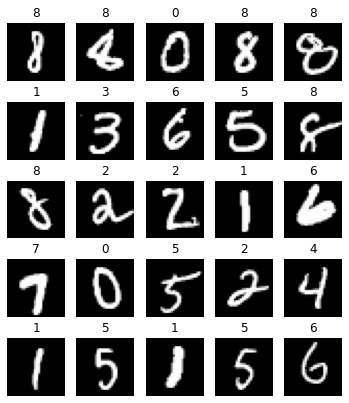

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [31]:
def init_layer(layer, mean=0, std=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [32]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
init_func = xavier
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    
print(len(layers))
del layers[-1]

66


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [33]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9876970648765564
forward 0.6912534236907959
forward 0.5447256565093994
forward 0.5014283061027527
forward 0.45471006631851196
forward 0.3671705424785614
forward 0.2944260537624359
forward 0.2830891013145447
forward 0.2757969796657562
forward 0.23911207914352417
forward 0.21181441843509674
forward 0.17875957489013672
forward 0.1689269095659256
forward 0.161423921585083
forward 0.1477324515581131
forward 0.15255582332611084
forward 0.1348893642425537
forward 0.14629310369491577
forward 0.16767063736915588
forward 0.17955197393894196
forward 0.19573873281478882
forward 0.152553990483284
forward 0.1314699649810791
forward 0.16610980033874512
forward 0.1327286958694458
forward 0.1294555366039276
forward 0.11828447133302689
forward 0.11532140523195267
forward 0.11065509170293808
forward 0.09817652404308319
forward 0.09273038059473038
forward 0.10984963923692703
forward 0.09390095621347427
backward 0.02905932441353798
backward 0.10209330916404724
backward 0.12403658777475357
backwar

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

Для He нормальное распределение, так что берем ту же функцию init_layer и функция активации - ReLU

In [36]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

def He(size_input, size_output):
    d = 2 / size_input
    return np.sqrt(d)

#init_func = normal
init_func = He
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


In [37]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9876970648765564
forward 0.7738039493560791
forward 0.8339107632637024
forward 0.8325180411338806
forward 0.800069272518158
forward 0.6693311929702759
forward 0.630920946598053
forward 0.7545945048332214
forward 0.6411485075950623
forward 0.5742329955101013
forward 0.45401597023010254
forward 0.48157498240470886
forward 0.4415735602378845
forward 0.2613478899002075
forward 0.21828515827655792
forward 0.18153604865074158
forward 0.16199178993701935
forward 0.12193766236305237
forward 0.12412714213132858
forward 0.10973301529884338
forward 0.07200934737920761
forward 0.052104078233242035
forward 0.03743618726730347
forward 0.03532978892326355
forward 0.02658078633248806
forward 0.02945343405008316
forward 0.031978756189346313
forward 0.03091174177825451
forward 0.018778054043650627
forward 0.019689468666911125
forward 0.014877713285386562
forward 0.015058178454637527
forward 0.009574830532073975
backward 0.02905932441353798
backward 0.09596872329711914
backward 0.06601045280694

##### Вроде хорошо считается

Берем равномерное распределение и инициализацию Xavier. Функцию активации - тангенс

In [38]:
def init_layer_uniform(layer, a=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-a, a)

In [39]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []


def xavier(size_input, size_output):
    a = (np.sqrt(6) / np.sqrt(size_input + size_output))
    return a


init_func = xavier

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer_uniform(layer, init_func(size_input, size_output)) # сюда надо подставить другие параметры
    
    layers.append(layer)
    layers.append(nn.Tanh())
    
print(len(layers))
del layers[-1]

66


In [40]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9876970648765564
forward 0.7042504549026489
forward 0.5527836084365845
forward 0.48034754395484924
forward 0.3933597505092621
forward 0.3593970239162445
forward 0.3098726272583008
forward 0.2862037420272827
forward 0.26256290078163147
forward 0.21238672733306885
forward 0.2038414180278778
forward 0.18299630284309387
forward 0.16842882335186005
forward 0.1350133866071701
forward 0.13382703065872192
forward 0.1213148683309555
forward 0.1281457543373108
forward 0.09953496605157852
forward 0.09676027297973633
forward 0.07028898596763611
forward 0.07995566725730896
forward 0.08230158686637878
forward 0.08192764967679977
forward 0.07666230946779251
forward 0.07873795926570892
forward 0.0687217116355896
forward 0.05381902679800987
forward 0.04690665379166603
forward 0.04480331018567085
forward 0.045433759689331055
forward 0.05161648988723755
forward 0.036677245050668716
forward 0.031274326145648956
backward 0.02905932441353798
backward 0.09181900322437286
backward 0.0571858733892440

Лосс падает и градиент не взрывается

<i> 1.4 Сделайте выводы по первой части </i>

Для активации ReLU лучше подходит инициализация He

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [8]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [9]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [44]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    #layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.042/0.096	Accuracy: 0.986/0.971


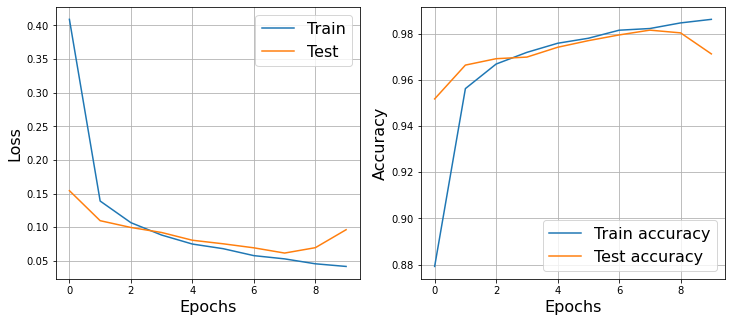

CPU times: user 3min 18s, sys: 11.5 s, total: 3min 29s
Wall time: 3min 33s


([0.4091063584727265,
  0.13901859117167464,
  0.10683715638559638,
  0.08844129174355982,
  0.07508124132900795,
  0.06819208426825972,
  0.05785127055110422,
  0.05303649885057688,
  0.045724801918757815,
  0.04178190433722077],
 [0.15443518305126624,
  0.10979515488577794,
  0.09971698550389538,
  0.09223854614869703,
  0.08073698630249954,
  0.07546130555410739,
  0.06946403120609024,
  0.061677200189213965,
  0.06967894804864368,
  0.09639124631221536],
 [0.8792311,
  0.95620114,
  0.96683437,
  0.9718872,
  0.975824,
  0.9779951,
  0.98147655,
  0.98220396,
  0.984636,
  0.98617405],
 [0.9517405,
  0.9663766,
  0.9691456,
  0.96983784,
  0.9740902,
  0.9769581,
  0.9794304,
  0.9815071,
  0.9803204,
  0.9712223])

In [45]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Тут пошло переобучение, похоже.. Ну dropout переобучение точно уберет))

In [52]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    #layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    layers.append(nn.Dropout(0.05))
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.060/0.056	Accuracy: 0.977/0.984


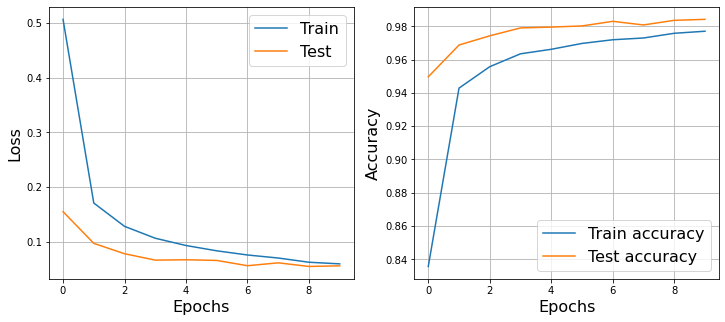

CPU times: user 3min 19s, sys: 11.4 s, total: 3min 31s
Wall time: 3min 32s


([0.5065887229147751,
  0.17076249284816702,
  0.12814572962648324,
  0.1063944351857405,
  0.09311508124809402,
  0.08339211935284677,
  0.07576823261167322,
  0.07022018507043563,
  0.06251552639586697,
  0.059537176342645305],
 [0.15504540701078462,
  0.09702117255405535,
  0.07807279651678062,
  0.06638410132189718,
  0.06704110321971954,
  0.06581413699903443,
  0.05614792175968237,
  0.06143303941994245,
  0.05482424993533641,
  0.05591933603937844],
 [0.8357543,
  0.94286937,
  0.9557458,
  0.9634806,
  0.9661958,
  0.96971065,
  0.9719261,
  0.9729811,
  0.97580737,
  0.97704005],
 [0.94966376,
  0.96875,
  0.974288,
  0.9790348,
  0.97952926,
  0.9802215,
  0.9829905,
  0.9808149,
  0.98358387,
  0.98417723])

In [53]:
%%time

#dropout
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Качество на тесте увеличилось. Но на трейне качество похуже, что объяснимо в принципе

In [58]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.131/0.258	Accuracy: 0.960/0.977


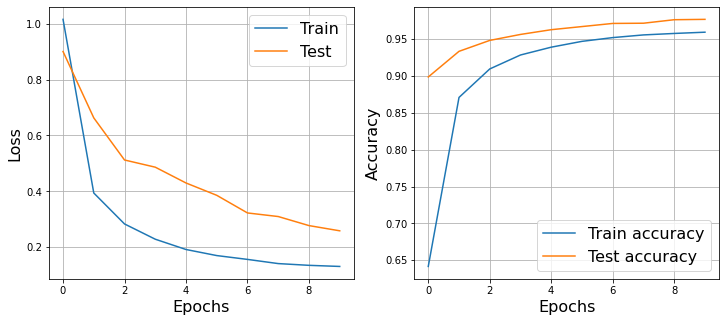

CPU times: user 3min 21s, sys: 22.8 s, total: 3min 43s
Wall time: 3min 40s


([1.0158285408386036,
  0.3939347107336719,
  0.283076154095913,
  0.2284129216536276,
  0.19155282523236802,
  0.16981677723718858,
  0.15607593872590358,
  0.14111139352864294,
  0.13486246744007951,
  0.1308722338244033],
 [0.9006717337083213,
  0.6629576731143119,
  0.5121215882510701,
  0.48638280334917805,
  0.42979298724094406,
  0.38561692861383307,
  0.32246421244477086,
  0.3096230620763844,
  0.2771630233537364,
  0.2584928879308031],
 [0.64161336,
  0.87106323,
  0.9097426,
  0.9286769,
  0.9392879,
  0.9471948,
  0.9522866,
  0.95592904,
  0.9579169,
  0.95962155],
 [0.8988331,
  0.9336432,
  0.948477,
  0.95658624,
  0.96301425,
  0.9672666,
  0.971519,
  0.97181565,
  0.9765625,
  0.977057])

In [59]:
%%time

#dropconnect
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Dropout работает здесь хорошо) Возможно, вероятность у DropConnect еще надо подобрать, но обычный Dropout пока справляется лучше))

Тут надо делать меньше Dropout.. для лучшей точности

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [16]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.eps = eps

    def forward(self, x):
        output = self.gamma * (x - torch.mean(x, dim=0, keepdim=True)) / (torch.std(x, dim=0, unbiased=True, keepdim=True) + self.eps) + self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [10]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    
    layers.append(layer)
    layers.append(nn.ReLU())
    layers.append(nn.BatchNorm1d(size_output))

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.021/0.065	Accuracy: 0.993/0.979


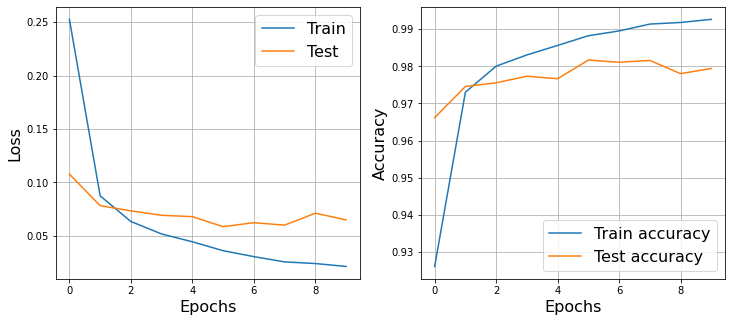

CPU times: user 3min 48s, sys: 13.1 s, total: 4min 1s
Wall time: 3min 50s


([0.25258666597433815,
  0.08746700973184442,
  0.06343128295269793,
  0.051778810144439816,
  0.04446618268335822,
  0.03611480380529598,
  0.030578194548741285,
  0.025647387782018433,
  0.024097603443053874,
  0.021392678289906555],
 [0.10774162581449823,
  0.07828584624619424,
  0.07340411980978295,
  0.06925276462342354,
  0.06799952154153888,
  0.058625662605030625,
  0.062319383202002775,
  0.06005105983076876,
  0.07122780402674328,
  0.06496201807049493],
 [0.9260894,
  0.9730366,
  0.9800551,
  0.9830812,
  0.98564655,
  0.9882563,
  0.98955005,
  0.99139905,
  0.99183214,
  0.9926706],
 [0.9661788,
  0.97458464,
  0.9755736,
  0.97735363,
  0.9766614,
  0.9817049,
  0.9811115,
  0.981606,
  0.9780459,
  0.9794304])

In [13]:
%%time

#Batch Normalization
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

In [17]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    
    layers.append(layer)
    layers.append(nn.ReLU())
    layers.append(LayerNormalization(size_output))

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.034/0.059	Accuracy: 0.989/0.982


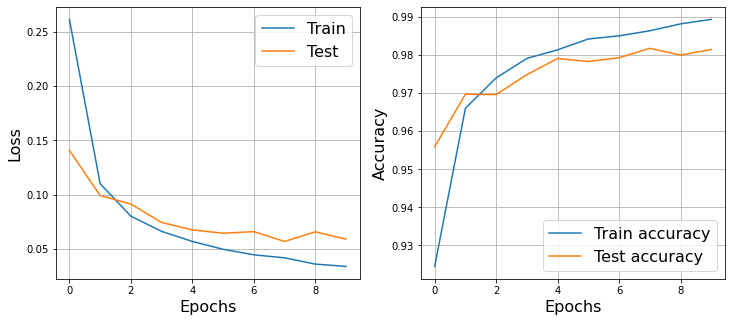

CPU times: user 3min 26s, sys: 23.7 s, total: 3min 50s
Wall time: 3min 46s


([0.2613367184535908,
  0.1100795365401359,
  0.08015645897861864,
  0.06620276232819948,
  0.05692699704982483,
  0.0497151839582603,
  0.04461723435789283,
  0.04184805936883015,
  0.03607473133314552,
  0.033914683813622386],
 [0.14076489210128784,
  0.09919772532921803,
  0.09135864533578293,
  0.07441010295495956,
  0.06753758445995141,
  0.06450404482598923,
  0.06595816308797538,
  0.056916944712070344,
  0.06580225306362668,
  0.05900228594111491],
 [0.9244625,
  0.96603477,
  0.97403604,
  0.97915,
  0.98141545,
  0.9842695,
  0.9850802,
  0.9864239,
  0.9882341,
  0.9894223],
 [0.955894,
  0.9697389,
  0.96964,
  0.97488135,
  0.9791337,
  0.9783426,
  0.9793315,
  0.9818038,
  0.98002374,
  0.9815071])

In [18]:
%%time

#Layer Normalization
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

Layer Normalization показала себя лучше. И переобучение меньше, и точность выше

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: